In [1]:
import numpy as np
from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'cpu')
import jax.numpy as jnp
from jax import jit, vmap
from ehrlich_aberth_jax import ehrlich_aberth

import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

gpu_ops: <module 'ehrlich_aberth_jax.gpu_ops' from '/home/fb90/miniforge3/envs/caustics/lib/python3.9/site-packages/ehrlich_aberth_jax/gpu_ops.cpython-39-x86_64-linux-gnu.so'>


In [2]:
def compute_polynomial_coeffs(a, w, e1):
    e2 = 1. - e1

    wbar = jnp.conj(w)
    wsqbar = jnp.conj(w**2)

    # Complex polynomial coefficients
    p5 = wsqbar - a**2
    p4 = wbar + a -2*e1*a - w*wsqbar + w*a**2
    p3 = -2*a*wbar + 2*a**4 - 2*w*wbar + 4*e1*a*wbar - 2*wsqbar*a**2
    p2 = -2*w*a**4 - 4*w*e1*a*wbar + 4*a**3*e1 + 2*w*wsqbar*a**2 - w - 2*a**3 -\
    a + 2*e1*a + 2*w*a*wbar
    p1 = 2*w*wbar*a**2 + wsqbar*a**4 + 2*wbar*a**3 - a**6 + 2*a**2 - 4*e1*a**2 +\
    4*e1**2*a**2 - 4*w*e1*a +2*w*a - 4*e1*a**3*wbar
    p0 = -2*e1*a**5 - a**3 + a**5 -4*w*e1**2*a**2 + 2*a**3*e1 + 4*w*a**3*wbar +\
    4*w*e1*a**2 - w*wbar*a**4 - 2*w*wbar*a**3 - w*a**2 + w*a**6 - a**4*wbar

    # p[5] + p[4]*z + p[3]*z**2 + p[2]*z**3 + p[1]*z**4 + p[0]*z**5
    p = jnp.array([p5, p4, p3, p2, p1, p0])
    
    return p

def plot_poly(p, l=4, roots=None):
    # Define 2D grid 
    npts = 250 

    x = jnp.linspace(-l, l, npts)
    y = jnp.linspace(-l, l, npts)

    xgrid, ygrid = jnp.meshgrid(x,y)
    wgrid = xgrid + 1j*ygrid

    # Evaluate abs(p(z)) on grid
    vals = jnp.abs(vmap(jnp.polyval, in_axes=(None, 0))(p, wgrid))

    fig, ax = plt.subplots(figsize=(6,4))

    im = ax.pcolormesh(xgrid, ygrid, jnp.log(vals))
    plt.colorbar(im)
    ax.set(xlabel='$\mathbb{R}(z)$', ylabel=r'$\mathbb{Im}(z)$')
    ax.set_aspect(1)
    ax.set(xlim=(-l,l), ylim=(-l,l))
    
    if roots is not None:
        ax.scatter(jnp.real(roots), jnp.imag(roots), marker='x', color='white')

In [3]:
# Define 2D grid in the source plane
npts = 1000
xrange = 5
yrange = 5

x = jnp.linspace(-0.5*xrange, 0.5*xrange, npts)
y = jnp.linspace(-0.5*xrange, 0.5*xrange, npts)
xgrid, ygrid = jnp.meshgrid(x,y)

# Lens mass ratio
e1 = 0.2

# Lens separation
a = 0.7

# Source position
wgrid = xgrid + 1j*ygrid 

# Compute complex polynomial coefficients for each source position
coeffs = vmap(vmap(lambda w: compute_polynomial_coeffs(a, w, e1)))(wgrid)
coeffs.shape

(1000, 1000, 6)

In [4]:
res = ehrlich_aberth(coeffs.reshape(-1, coeffs.shape[-1]))
res_reshaped = res.reshape((coeffs.shape[0], coeffs.shape[1], 5))

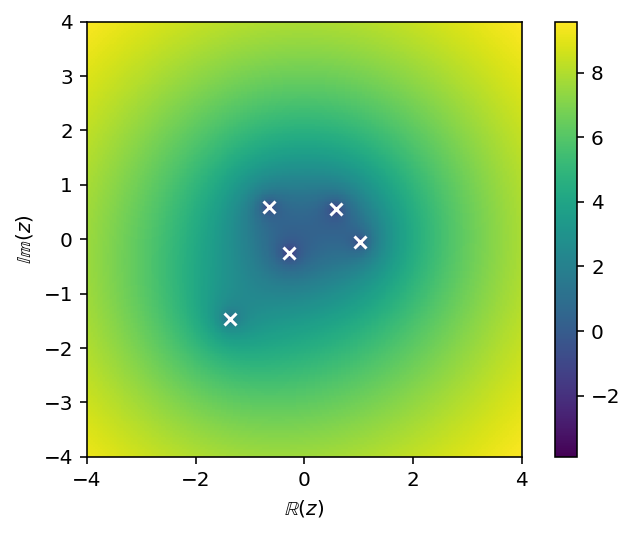

In [5]:
plot_poly(coeffs[300, 280], roots=res_reshaped[300,280])

In [ ]:
%%timeit
ehrlich_aberth(coeffs)